# Navigation


This Notebooks uses Unity's ML-Agents to solve a simple navigation task where our agent has to collect as many yellow bananas as possible in the given time.


### Set up

This code uses UnityEnvironment (In this case is a customized version from Udacity), [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/)

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### The Environment

This simulation contains a single agent that navigates a large environment.  

At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

### Method

This task has been solved using a Prioritized Experience Replay - Double Deep Q-Network (PER-DDQN), part of the code for enabling the environment has been extracted from Udacity's example.

#### Deep Q-Network

The base implementation comes from the famous ["Playing Atari with Deep Reinforcement Learning"](https://arxiv.org/abs/1312.5602) from deep mind, where several games of Atari were played by Reinforcement Learning agents trained solely on visual information from the game (The only data that was extracted was the score), hence learning the game as most likely any human player would have. This development had 2 important parts: Describing the Convolutional Neural Network needed to extract image features directly from the game screen. Unlike a traditional reinforcement learning set up where only one Q value will be produced, the Deep Q-Network will produce Q values for all possible actions (hence approximating the value-state function). To find a optimal policy we will need quite a big amount of data, and even this data will have a high correlation between certain state and actions, what will make our model overfit for certain experiences. The DeepMind team introduced 2 well known techniques:

- Experience Replay

The sequence of experiences can be highly correlated. Q-learning algorithm that learns from each of these experience tuples in sequential order runs the risk of being affected by the correlation in this sequences. By instead keeping track of a replay buffer and using experience replay to sample from the buffer stochasticaly, we can prevent action values from oscillating or diverging.

- Fixed targets ( 2 networks)

In Q-Learning, we update an approximation using the same approxiamtion, and this can potentially lead to harmful correlations. To avoid this, we introduce 2 networks that will learn over the same data, but we will have different update rates for them, then we can change slightly our error function (TD Learning function) by fixing our TD-Target using the parameters of a network that gets updated less frequently, we call this fixed targets. And it just helps stabilizing the learning target.
![Double DQN Error formula](fixed-targets.PNG "Double DQN")

#### Double Deep Q-Network

One of the proposals to improve DQNs is [Double DQN](https://arxiv.org/pdf/1509.06461.pdf). The current [strategy in DQNs to calculate Q-Values is prompt to overestimation](https://www.ri.cmu.edu/pub_files/pub1/thrun_sebastian_1993_1/thrun_sebastian_1993_1.pdf), meaning that in the early stages of the training, our Q values won't be reliable, hence we could be taking a wrong action and later on keep choosing the same action as we are picking the max in a set of noisy values. To make this approximation more resiliant we played with the fact of having 2 sets of different parameters, then we can split the evaluation and selections of policies during training preventing policies from being repeatedly selected by chance. We can consider this a slightly modification to the fixed targets improvement.

![Double DQN Error formula](ddqn-formula.PNG "Double DQN")

#### Prioritized Experience Replay

As a modification to the experience Replay Feature, we introduce [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952). The assumption is that not all our experiences are as fructful for our training as others thereby by identifying the most relevant experiences and using them more often to train our network we could achieve better results and performance. We define a more relevant experience by the error, hence experiences with a higher error are more likely to introduce bigger and more relevant changes to our network. Once we can add a priority to our experiences based on the error, we can sample our memory buffer stochastically using a probability based on their priority (non-uniform). Technically, to improve performance during training we need a priority heap to reduce the time to sampling and update of our prioritized experience replay buffer

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### Training the agent

In [7]:
from agent import Agent


agent = Agent(state_size=state_size, action_size=action_size, gamma = 0.99, tau = 1e-3, lr = 5e-4, update_every = 4)

In [8]:
from collections import namedtuple, deque, defaultdict
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def dqn(n_episodes=900, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done, i_episode)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

Episode 100	Average Score: 1.33
Episode 200	Average Score: 5.17
Episode 300	Average Score: 8.76
Episode 400	Average Score: 10.38
Episode 500	Average Score: 12.25
Episode 600	Average Score: 13.96
Episode 700	Average Score: 15.26
Episode 800	Average Score: 14.41
Episode 900	Average Score: 15.88


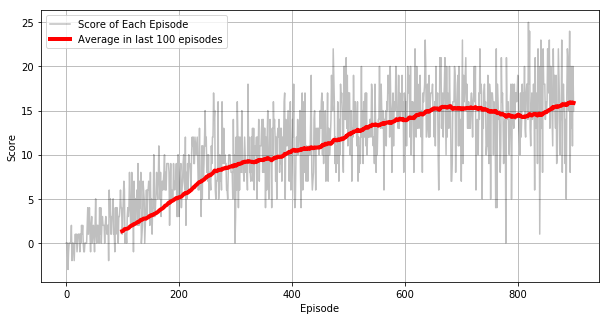

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(1, 1, figsize=[10, 5])

score_average_window = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="black", alpha=0.25)
ax.plot(score_average_window, "-", c="red", linewidth=4)

ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.legend(["Score of Each Episode", "Average in last 100 episodes"])


### Observe independent agent

In [16]:
# load the weights from file
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    
    for j in range(200):
        action = agent.act(state).astype(int)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        done = env_info.local_done[0]
        if done:
            break

In [17]:
env.close()